# Naive word2vec

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch (numpy too, if you love to calculate gradients on your own and want some extra points, but don't forget to numerically check your gradients) and code from your previous task. Again: you don't have to implement negative sampling (you may reduce your vocabulary size for faster computation).

**Results of this task**:
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)
 * qualitative evaluations of word vectors: nearest neighbors, word analogies

**Extra:**
 * quantitative evaluation:
   * for intrinsic evaluation you can find datasets [here](https://aclweb.org/aclwiki/Analogy_(State_of_the_art))
   * for extrincis evaluation you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

Also, you can find any other datasets for quantitative evaluation. If you chose to do this, please use the same datasets across tasks 3, 4, 5 and 6.

Again. It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)

If you struggle with something, ask your neighbor. If it is not obvious for you, probably someone else is looking for the answer too. And in contrast, if you see that you can help someone - do it! Good luck!

In [1]:
from pathlib import Path
from collections import Counter
from itertools import islice, product, chain
from argparse import Namespace

from tqdm import tqdm_notebook

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tensorboardX import SummaryWriter
from annoy import AnnoyIndex

In [2]:
DATA_PATH = Path('../data')
MODELS_PATH = Path('../models')

In [3]:
class SkipGramBatcher():
    def __init__(self, text):
        self.text = text
    
    @classmethod
    def from_file(cls, file_path):
        with open(file_path) as f:
            text = f.read()
        
        return cls(text)
    
    def _tokenize(self):
        self.tokens = self.text.split()
    
    def _count_tokens(self):
        self.token_counts = Counter(self.tokens)
    
    def _build_vocab(self, cutoff):
        filtered_token_counts = dict(filter(lambda x: x[1] >= cutoff, self.token_counts.items()))
        self.token_to_idx = {token:idx for (idx, (token, _)) 
                             in enumerate(filtered_token_counts.items())}
        self.idx_to_token = {idx:token for (token, idx) in self.token_to_idx.items()}
        self.vocab = set(self.token_to_idx)

    def _filter_tokens(self):
        self.tokens = [token for token in self.tokens if token in self.vocab]
    
    def _vectorize_tokens(self):
        self.vectorized_tokens = [self.token_to_idx[token] for token in self.tokens]
    
    def _create_sliding_window(self, window_size, stride):
        tokens_size = len(self.tokens)

        for i in range(0, tokens_size, stride):
#             center_word = islice(self.vectorized_tokens, i, i + 1)
#             left_context = islice(self.vectorized_tokens, i + 1, 
#                                   min(tokens_size, i + window_size + 1))
#             right_context = islice(self.vectorized_tokens, 
#                                    max(0, i - window_size), i)
#             yield from product(center_word, chain(left_context, right_context))

#             window_size = np.random.randint(1, max_window_size+1)
            center_word = self.vectorized_tokens[i:i+1]
            left_context = self.vectorized_tokens[max(0, i - window_size): i]
            right_context = self.vectorized_tokens[i + 1: min(tokens_size, i + window_size + 1)]
            yield from product(center_word, chain(left_context, right_context))
        
    def devectorize_tokens(self, indices):
        return [self.idx_to_token[idx] for idx in indices]
        
    def prepare_data(self, cutoff=1):
        self._tokenize()
        self._count_tokens()
        self._build_vocab(cutoff)
        self._filter_tokens()
        self._vectorize_tokens()
        
    def generate_batches(self, window_size=1, stride=1, batch_size=1, drop_last=True):
        window = self._create_sliding_window(window_size, stride)
        batch = list(zip(*islice(window, batch_size)))
        x_batch, labels_batch = torch.tensor(batch[0]), torch.tensor(batch[1])

        if drop_last:
            while batch and len(batch[0]) == batch_size:
                yield x_batch, labels_batch
                batch = list(zip(*islice(window, batch_size)))
                x_batch, labels_batch = torch.tensor(batch[0]), torch.tensor(batch[1])
        else:
            while batch:
                yield x_batch, labels_batch
                batch = list(zip(*islice(window, batch_size)))
                x_batch, labels_batch = torch.tensor(batch[0]), torch.tensor(batch[1])

In [4]:
class NaiveWord2VecClassifier(nn.Module):
    def __init__(self, vocabulary_size, embedding_size):
        super().__init__()
        
#         self.embedding = nn.utils.weight_norm(nn.Embedding(num_embeddings=vocabulary_size,
#                                       embedding_dim=embedding_size), dim=1)
# #                                       max_norm=1.0)
# #                                       scale_grad_by_freq=True)
                                      
#         self.fc1 = nn.utils.weight_norm(nn.Linear(in_features=embedding_size,
#                              out_features=vocabulary_size,
#                              bias=False), dim=1)

        self.embedding = nn.utils.weight_norm(nn.Embedding(num_embeddings=vocabulary_size,
                                              embedding_dim=embedding_size), dim=1)

        self.fc1 = nn.utils.weight_norm(nn.Linear(in_features=embedding_size,
                             out_features=vocabulary_size,
                             bias=False), dim=1)
        
    def forward(self, x_in):
#         self.embedding.weight.data = F.normalize(self.embedding.weight.data, p=2, dim=1)
#         self.fc1.weight.data = F.normalize(self.fc1.weight.data, p=2, dim=1)
        x_embedded = self.embedding(x_in)
        y_out = self.fc1(x_embedded)
        
        return y_out

In [5]:
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [6]:
args = Namespace(
    file_path = DATA_PATH/'text8',
    model_state_path = MODELS_PATH/'naive_word2vec_embeddings.pth',
    weights_path = MODELS_PATH/'weights.npz',
    
    embedding_size = 100,
    
    seed = 42,
    cutoff = 10, # 10
    window_size = 3, # 1
    stride = 1, # 1
    batch_size = 1024, #  1024
    learning_rate = 0.03, # 0.03
    iterations = 1000,
    save_iterations = 100,
    early_stopping_criteria = 1e8,
    factor=0.5, # 0.7
    patience=5000, # 1000
    
    cuda=True
)

In [7]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': [], # args.learning_rate
            'batch_idx': 0,
            'loss': [],
            'model_file_name': args.model_state_path}

def update_train_state(args, model, train_state):
    if train_state['batch_idx'] == 0:
        train_state['stop_early'] = False
        torch.save(model.state_dict(), train_state['model_file_name'])
    else:
        loss = train_state['loss'][-1]

        if loss < train_state['early_stopping_best_val']:
            train_state['early_stopping_best_val'] = loss
            train_state['early_stopping_step'] = 0
            
            if train_state['batch_idx'] % args.save_iterations == 0:
                torch.save(model.state_dict(), train_state['model_file_name'])
        else:
            train_state['early_stopping_step'] += 1 
    
        train_state['stop_early'] = train_state['early_stopping_step'] >= args.early_stopping_criteria
    return train_state

In [8]:
if not torch.cuda.is_available():
    args.cuda=False
    
print(f'Using CUDA: {args.cuda}')
args.device = torch.device('cuda' if args.cuda else 'cpu')

Using CUDA: True


In [9]:
sg_batcher = SkipGramBatcher.from_file(args.file_path)
sg_batcher.prepare_data(cutoff=args.cutoff)

vocabulary_size = len(sg_batcher.vocab)
vocabulary_size

47134

In [10]:
set_seeds(args.seed)

classifier = NaiveWord2VecClassifier(vocabulary_size=vocabulary_size,
                                     embedding_size=args.embedding_size)
classifier = classifier.to(args.device)

loss_func = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(params=classifier.parameters(),
                      lr=args.learning_rate)

epoch_size = 2 * (args.window_size * len(sg_batcher.tokens) 
                  - np.math.factorial(args.window_size)) // (args.batch_size * args.stride)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min',
                                                 factor=args.factor,
                                                 patience=args.patience)

train_bar = tqdm_notebook(desc='Training',
                          position=1,
#                           total=args.iterations,
                          total=epoch_size)

batch_generator = sg_batcher.generate_batches(window_size=args.window_size, 
                                              batch_size=args.batch_size)

train_state = make_train_state(args)

writer = SummaryWriter(log_dir='logs/task_3', comment='embedding_training')

running_loss = 0.
classifier.train()

try:
    for batch_idx, (x_batch, labels_batch) in enumerate(batch_generator, 1):
        x_batch = x_batch.to(args.device)
        labels_batch = labels_batch.to(args.device)

        optimizer.zero_grad()

        y_pred = classifier(x_in=x_batch)

        loss = loss_func(y_pred, labels_batch)
        loss_value = loss.item()
        running_loss += (loss_value - running_loss) / (batch_idx)
        loss.backward()
        
        learning_rate = optimizer.param_groups[0]['lr']
        
        train_state['batch_idx'] = batch_idx
        train_state['loss'].append(running_loss)
        train_state['learning_rate'].append(learning_rate)
#         writer.add_scalar('loss', scalar_value=loss, global_step=batch_idx)


        train_state = update_train_state(args=args,
                                         model=classifier,
                                         train_state=train_state)

        train_params = dict(loss=running_loss,
                            lr=learning_rate,
                            early_step=train_state['early_stopping_step'],
                            early_best=train_state['early_stopping_best_val'])
        train_bar.set_postfix(train_params)
        train_bar.update()
        
        optimizer.step()
        
        scheduler.step(train_state['loss'][-1])

        if train_state['stop_early'] or (batch_idx == epoch_size):
            torch.save(classifier.state_dict(), str(train_state['model_file_name']) + '_last')
            break
except KeyboardInterrupt:
    print('Exit training')

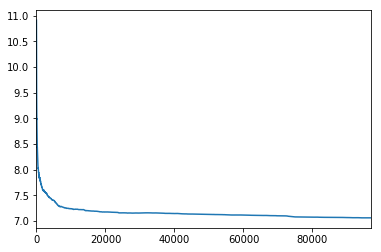

In [11]:
train_state_df = pd.DataFrame(train_state)
train_state_df['loss'].plot()
plt.show()

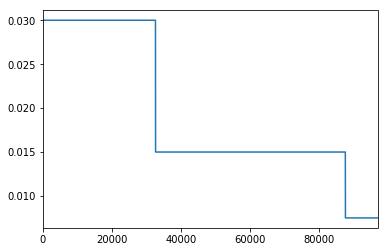

In [12]:
train_state_df['learning_rate'].plot()
plt.show()

In [13]:
metadata = list(sg_batcher.token_to_idx)
W = classifier.embedding.weight.detach().cpu().numpy()
W_prime = classifier.fc1.weight.detach().cpu().numpy()

W_avg = (W + W_prime) / 2
np.savez(args.weights_path, W=W, W_prime=W_prime, W_avg=W_avg)

In [14]:
classifier.embedding.weight_g.shape, classifier.embedding.weight_v.shape

(torch.Size([1, 100]), torch.Size([47134, 100]))

In [15]:
classifier.fc1.weight_g.shape, classifier.fc1.weight_v.shape

(torch.Size([1, 100]), torch.Size([47134, 100]))

In [64]:
# writer.add_embedding(W, metadata=metadata, tag='W')
# writer.add_embedding(W_prime, metadata=metadata, tag='W_prime')
# writer.add_embedding(W_avg, metadata=metadata, tag='W_avg')

In [37]:
weights = np.load(args.weights_path)
W = weights['W']
W_prime = weights['W_prime']
W_avg = weights['W_avg']

In [38]:
W.min(), W.max(), W_prime.min(), W_prime.max()

(-15.041774, 13.829485, -0.60154366, 0.5448065)

In [80]:
W_norm = W / np.linalg.norm(W, axis=1, keepdims=True)
W_prime_norm = W_avg / np.linalg.norm(W_prime, axis=1, keepdims=True)
W_avg_norm = (W_norm + W_prime_norm) / 2
np.abs(W_norm).max(), np.abs(W_prime_norm).max(), np.abs(W_avg_norm).max()

(1.0, 19.550741, 9.950522)

In [16]:
from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
from umap import UMAP

In [17]:
def plot_embeddings(embs_reduced, token_to_idx, tokens):
    token_embs = embs_reduced[[token_to_idx[token] for token in tokens]]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.scatter(token_embs[:, 0], token_embs[:, 1], alpha=0.2)
    
    for i, token in enumerate(tokens):
        ax.annotate(token, (token_embs[i, 0], token_embs[i, 1]))

In [121]:
%%time
pca = PCA(n_components=2)
embs_pca = pca.fit_transform(W_avg)

CPU times: user 336 ms, sys: 4 ms, total: 340 ms
Wall time: 87.8 ms


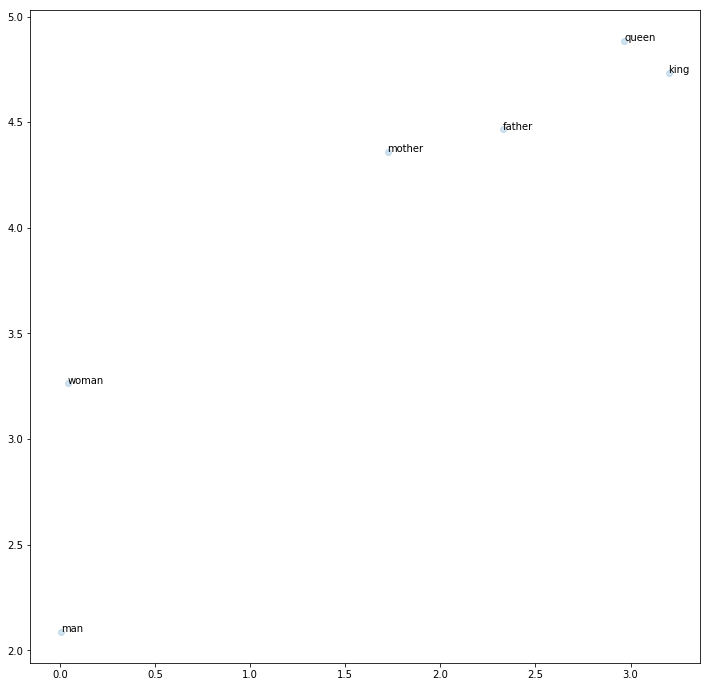

In [122]:
tokens = ['man', 'woman', 'king', 'queen', 'mother', 'father']
# tokens = list(dict(sg_batcher.token_counts.most_common(100)).keys())
plot_embeddings(embs_pca, sg_batcher.token_to_idx, tokens)

In [ ]:
%%time
tsne = TSNE(n_components=2, n_iter=1000, n_jobs=-1)
embs_tsne = tsne.fit_transform(W_avg)

In [ ]:
tokens = ['man', 'woman', 'king', 'queen', 'mother', 'father']
# tokens = list(dict(sg_batcher.token_counts.most_common(100)).keys())
plot_embeddings(embs_tsne, sg_batcher.token_to_idx, tokens)

In [ ]:
%%time
umap = UMAP(metric='cosine')
embs_umap = umap.fit_transform(W_avg)

In [ ]:
tokens = ['man', 'woman', 'king', 'queen', 'mother', 'father']
# tokens = list(dict(sg_batcher.token_counts.most_common(100)).keys())
plot_embeddings(embs_umap, sg_batcher.token_to_idx, tokens)

In [123]:
class EmbeddingsExplorer():
    def __init__(self, token_to_idx, vectors, metric='euclidean'):
        self.token_to_idx = token_to_idx
        self.idx_to_token = {idx: token for token, idx 
                             in self.token_to_idx.items()}
        self.vectors = vectors
        self.metric = metric
        
        self.index = AnnoyIndex(vectors.shape[1], metric=metric)
        
        print('Building index is started')
        for i in self.token_to_idx.values():
            self.index.add_item(i, self.vectors[i])
        
        self.index.build(50)
        print('Building index is finished')
        
    def get_embedding(self, token):
        return self.vectors[self.token_to_idx[token]]
    
    def get_closest_to_vector(self, vector, n=1):
        nn_indices = self.index.get_nns_by_vector(vector, n)
        return [self.idx_to_token[neighbor] for neighbor in nn_indices]
    
    def compute_analogy(self, token1, token2, token3, n=20):
        vec1 = self.get_embedding(token1)
        vec2 = self.get_embedding(token2)
        vec3 = self.get_embedding(token3)
        vec4 = vec3 + vec2 - vec1
        
        tokens = set([token1, token2, token3])
        closest_tokens = self.get_closest_to_vector(vec4, n=n)
        closest_tokens = [token for token in closest_tokens
                          if token not in tokens]
        
        if len(closest_tokens) == 0:
            print('Could not find nearest neighbors for the computed vector')
            return
        
        for token4 in closest_tokens:
            print(f'{token1}:{token2} :: {token3}:{token4}')

In [154]:
embeddings = EmbeddingsExplorer(sg_batcher.token_to_idx, W_avg, metric='euclidean')
embeddings

Building index is started
Building index is finished


In [155]:
# man:he :: woman:(she)
embeddings.compute_analogy('man', 'he', 'woman')

man:he :: woman:she
man:he :: woman:briefly
man:he :: woman:prison
man:he :: woman:herself
man:he :: woman:afterwards
man:he :: woman:subsequently
man:he :: woman:himself
man:he :: woman:him
man:he :: woman:parents
man:he :: woman:publicly
man:he :: woman:again
man:he :: woman:marry
man:he :: woman:apparently
man:he :: woman:secretly
man:he :: woman:marriage
man:he :: woman:succeed
man:he :: woman:wounded
man:he :: woman:reportedly
man:he :: woman:abroad


In [175]:
# fly:plane :: sail:(ship)
embeddings.compute_analogy('fly', 'plane', 'sail')

fly:plane :: sail:circle
fly:plane :: sail:arc
fly:plane :: sail:column
fly:plane :: sail:rotation
fly:plane :: sail:outer
fly:plane :: sail:ring
fly:plane :: sail:arch
fly:plane :: sail:intersection
fly:plane :: sail:probe
fly:plane :: sail:imaginary
fly:plane :: sail:curvature
fly:plane :: sail:burst
fly:plane :: sail:mound
fly:plane :: sail:gate
fly:plane :: sail:crest
fly:plane :: sail:junction
fly:plane :: sail:stream
fly:plane :: sail:orbital
fly:plane :: sail:loop


In [157]:
# kitten:cat :: puppy:dog
embeddings.compute_analogy('kitten', 'cat', 'puppy')

kitten:cat :: puppy:dog
kitten:cat :: puppy:bird
kitten:cat :: puppy:wolf
kitten:cat :: puppy:magic
kitten:cat :: puppy:soup
kitten:cat :: puppy:cow
kitten:cat :: puppy:pepper
kitten:cat :: puppy:tiger
kitten:cat :: puppy:horn
kitten:cat :: puppy:monster
kitten:cat :: puppy:flower
kitten:cat :: puppy:killer
kitten:cat :: puppy:beast
kitten:cat :: puppy:pet
kitten:cat :: puppy:chorus
kitten:cat :: puppy:honey
kitten:cat :: puppy:jacket
kitten:cat :: puppy:rabbit
kitten:cat :: puppy:grass


In [158]:
# blue:color :: dog:(breed)
embeddings.compute_analogy('blue', 'color', 'dog')

blue:color :: dog:breed
blue:color :: dog:fitting
blue:color :: dog:joke
blue:color :: dog:straightforward
blue:color :: dog:confusing
blue:color :: dog:perfect
blue:color :: dog:trick
blue:color :: dog:realistic
blue:color :: dog:humorous
blue:color :: dog:stupid
blue:color :: dog:luck
blue:color :: dog:clip
blue:color :: dog:mirrors
blue:color :: dog:puzzle
blue:color :: dog:voice
blue:color :: dog:meter
blue:color :: dog:fancy
blue:color :: dog:bunch
blue:color :: dog:typing


In [159]:
# leg:legs :: hand:(hands)
embeddings.compute_analogy('leg', 'legs', 'hand')

leg:legs :: hand:fingers
leg:legs :: hand:side
leg:legs :: hand:hands
leg:legs :: hand:shoulder
leg:legs :: hand:neck
leg:legs :: hand:face
leg:legs :: hand:clothes
leg:legs :: hand:surfaces
leg:legs :: hand:edges
leg:legs :: hand:bodies
leg:legs :: hand:finger
leg:legs :: hand:horns
leg:legs :: hand:teeth
leg:legs :: hand:balls
leg:legs :: hand:shoulders
leg:legs :: hand:holes
leg:legs :: hand:wooden
leg:legs :: hand:sticks


In [160]:
# toe:finger :: foot:(hand)
embeddings.compute_analogy('toe', 'finger', 'foot')

toe:finger :: foot:leg
toe:finger :: foot:neck
toe:finger :: foot:legs
toe:finger :: foot:arm
toe:finger :: foot:fingers
toe:finger :: foot:bottom
toe:finger :: foot:floor
toe:finger :: foot:shoulder
toe:finger :: foot:tail
toe:finger :: foot:bow
toe:finger :: foot:deck
toe:finger :: foot:edges
toe:finger :: foot:stones
toe:finger :: foot:wheel
toe:finger :: foot:rear
toe:finger :: foot:walking
toe:finger :: foot:face
toe:finger :: foot:wings


In [161]:
# talk:communicate :: read:(interpret)
embeddings.compute_analogy('talk', 'communicate', 'read')

talk:communicate :: read:translate
talk:communicate :: read:manipulate
talk:communicate :: read:commands
talk:communicate :: read:modify
talk:communicate :: read:integrate
talk:communicate :: read:reproduce
talk:communicate :: read:identify
talk:communicate :: read:detect
talk:communicate :: read:confuse
talk:communicate :: read:render
talk:communicate :: read:overcome
talk:communicate :: read:execute
talk:communicate :: read:automatically
talk:communicate :: read:checking
talk:communicate :: read:classify
talk:communicate :: read:dynamically
talk:communicate :: read:modifications
talk:communicate :: read:instructions


In [162]:
# man:king :: woman:(queen)
embeddings.compute_analogy('man', 'king', 'woman')

man:king :: woman:viii
man:king :: woman:prince
man:king :: woman:son
man:king :: woman:vii
man:king :: woman:heir
man:king :: woman:crowned
man:king :: woman:henry
man:king :: woman:queen
man:king :: woman:elizabeth
man:king :: woman:iii
man:king :: woman:augustus
man:king :: woman:khan
man:king :: woman:cousin
man:king :: woman:daughter
man:king :: woman:constantine
man:king :: woman:princess
man:king :: woman:grandson
man:king :: woman:bishop
man:king :: woman:clement


In [163]:
# man:doctor :: woman:(job title)
embeddings.compute_analogy('man', 'doctor', 'woman')

man:doctor :: woman:nurse
man:doctor :: woman:secretly
man:doctor :: woman:colleague
man:doctor :: woman:lawyer
man:doctor :: woman:farmer
man:doctor :: woman:mrs
man:doctor :: woman:gertrude
man:doctor :: woman:child
man:doctor :: woman:nude
man:doctor :: woman:twins
man:doctor :: woman:stern
man:doctor :: woman:fellow
man:doctor :: woman:blonde
man:doctor :: woman:oswald
man:doctor :: woman:teenager
man:doctor :: woman:mortal
man:doctor :: woman:lover
man:doctor :: woman:reverend


In [167]:
# fast:fastest :: small:smallest
embeddings.compute_analogy('fast', 'fastest', 'rich')

fast:fastest :: rich:richest
fast:fastest :: rich:landscape
fast:fastest :: rich:wealthiest
fast:fastest :: rich:poorest
fast:fastest :: rich:predominant
fast:fastest :: rich:sparsely
fast:fastest :: rich:northeastern
fast:fastest :: rich:strongest
fast:fastest :: rich:principal
fast:fastest :: rich:americas
fast:fastest :: rich:northernmost
fast:fastest :: rich:lowlands
fast:fastest :: rich:uzbekistan
fast:fastest :: rich:coastal
fast:fastest :: rich:overwhelmingly
fast:fastest :: rich:abundant
fast:fastest :: rich:fiji
fast:fastest :: rich:highland
fast:fastest :: rich:nordic


In [58]:
sg_batcher = SkipGramBatcher.from_file(args.file_path)
sg_batcher.prepare_data(cutoff=100000)

In [59]:
g = sg_batcher.generate_batches(window_size=5, 
                                batch_size=5)
x_batch, labels_batch = next(g)

x_batch, labels_batch

(tensor([0, 0, 0, 0, 0]), tensor([1, 2, 3, 2, 3]))

In [60]:
vocabulary_size = len(sg_batcher.vocab)
embedding_size = 50

vocabulary_size, embedding_size

(22, 50)

In [61]:
clf = NaiveWord2VecClassifier(vocabulary_size=vocabulary_size,
                              embedding_size=embedding_size)

In [102]:
y_pred = clf(x_batch)
# y_pred = F.softmax(y_pred, dim=1)
y_pred

tensor([[ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.0782,  0.1542, -0.5275, -0.5969, -0.2852,  0.9326, -0.0609,  1.0134,
          0.7858, -0.3970, -0.0972,  0.2352, -0.1621, -0.3524],
        [ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.0782,  0.1542, -0.5275, -0.5969, -0.2852,  0.9326, -0.0609,  1.0134,
          0.7858, -0.3970, -0.0972,  0.2352, -0.1621, -0.3524],
        [ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.0782,  0.1542, -0.5275, -0.5969, -0.2852,  0.9326, -0.0609,  1.0134,
          0.7858, -0.3970, -0.0972,  0.2352, -0.1621, -0.3524],
        [ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.0782,  0.1542, -0.5275, -0.5969, -0.2852,  0.9326, -0.0609,  1.0134,
          0.7858, -0.3970, -0.0972,  0.2352, -0.1621, -0.3524],
        [ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.078

In [79]:
labels_batch

tensor([1, 2, 3, 2, 3])

In [103]:
y_pred[range(5), labels_batch]

tensor([-0.7678, -0.4254,  0.3084, -0.4254,  0.3084], grad_fn=<IndexBackward>)

In [80]:
-torch.log(y_pred[range(5), labels_batch])

tensor([3.9903, 3.6480, 2.9141, 3.6480, 2.9141], grad_fn=<NegBackward>)

In [95]:
y_true = torch.zeros((5, vocabulary_size), dtype=torch.long)
y_true[range(5), labels_batch] = 1

In [92]:
y_true.shape, y_pred.shape

(torch.Size([5, 22]), torch.Size([5, 22]))

In [104]:
loss = nn.CrossEntropyLoss(reduce=False)
loss(y_pred, labels_batch)

/opt/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


tensor([3.9903, 3.6480, 2.9141, 3.6480, 2.9141], grad_fn=<NllLossBackward>)

In [64]:
arr = torch.zeros((5, vocabulary_size))
arr[range(5), labels_batch] = 1
arr.sum(dim=1)

tensor([1., 1., 1., 1., 1.])

In [65]:
labels_batch

tensor([1, 2, 3, 2, 3])

In [70]:
loss = -np.log()

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
